In [1]:
# Hide TensorFlow verbose logs so they don't pollute the notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
from tensorflow.keras import layers, models, datasets, callbacks

# Load the Fashion MNIST dataset, splitting it into training and testing sets.
# x_train, x_test: Grayscale images (originally 28x28 pixels, 0-255 values).
# y_train, y_test: Integer labels (0-9).
(x_train,y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()

# Pre-process the MNIST dataset to be easier to work with.
# 1. Normalize pixel values: Convert to float32 and scale from 0-255 to 0.0-1.0.
# 2. Pad images: Add 2 pixels of zero-padding around each 28x28 image,
#    making them 32x32 pixels. This helps with common CNN input sizes.
# 3. Add channel dimension: For grayscale images, add a channel dimension of 1
#    (e.g., from (32, 32) to (32, 32, 1)). This is required by Keras Conv2D layers.
def preprocess_mnist_image(images):
    images = images.astype("float32") / 255.0
    images = np.pad(images, ((0,0), (2,2), (2,2)), constant_values = 0.0)
    images = np.expand_dims(images, -1)
    return images

x_train = preprocess_mnist_image(x_train)
x_test = preprocess_mnist_image(x_test) 

2025-07-11 00:51:16.444451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752209476.465534    7227 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752209476.471515    7227 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752209476.492244    7227 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752209476.492270    7227 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752209476.492272    7227 computation_placer.cc:177] computation placer alr

## Encoders

Encoders can be thought of as feature extractors. They take raw input (in our case, MNIST images) and compress them 
into a compact but informative representation in a latent space/embedding space (the space of all possible outcomes of outputs). So an image, such as pants with pockets, may be encoded into an embedding within the MNIST dataset's latent space, such as coordinates (5.5, -6.3). This isn't just about shrinking data; it's about making it understandable for downstream tasks by highlighting the key underlying features.

## Decoders

Decoders are the counterparts to encoders. Given an encoding/embedding/latency representation, they expand it back into an output. Going with the previous example, a decoder may take the (5.5, -6.3) coordinate and turn it back into an image with pants with pockets. 

## Autoencoders

Autoencoders are made up of encoders and decoders. An autoencoder can take an image, encode it into an embedding, and then decode that same embedding into a similar image as the input. In other words, it can take an image, map it to a point in its embedding space (or latent space), and generate some facsimile of the original version. 

## Encoding: Mapping to a Latent Space

To do all that, we will first need to embed images into a latent space using an encoder.

In [2]:
encoder_input = layers.Input(shape=(32,32,1), name="encoder_input")

# Our encoder will progressively extract features and reduce the dimensionality
# of the input image, mapping it to a lower-dimensional latent space.
# Output shape after this layer: (16, 16, 32)
x = layers.Conv2D(32, (3,3), strides=2, activation="relu", padding="same")(encoder_input)
# Output shape after this layer: (8, 8, 64)
x = layers.Conv2D(64, (3,3), strides=2, activation="relu", padding="same")(x)
# Output shape after this layer: (4, 4, 128)
x = layers.Conv2D(128, (3,3), strides=2, activation="relu", padding="same")(x)

## We'll need this shape later, when we create the decoder.
import tensorflow.keras.backend as K
shape_before_flattening = K.int_shape(x)[1:]

# Finally, we flatten the 3D output of the last convolutional layer (4x4x128) into 
# a 1D vector (4 * 4 * 128 = 2048 elements).
# This is necessary to connect to a fully connected (Dense) layer. Yes, by flattening,
# we DO lose the spatial ifnormation about features that were next to each other in the 
# 2D maps, because the 2D grid structure gets flattened. 
# However, we assume this spatial relationship information has already been effectively captured
# and encoded by the preceding Conv2D layers.
x = layers.Flatten()(x)

# Finally, we create a fully-connected output layer. We specify 2 units, as the dimensionality of
# the latent space representation. Thus, each input image will be compressed into a 2-dimensional vector.
encoder_output = layers.Dense(2, name="encoder_output")(x)



encoder = models.Model(encoder_input, encoder_output)

I0000 00:00:1752209480.531664    7227 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:0b:00.0, compute capability: 8.6


## Decoder

The decoder does the opposite of the encoder - as such, instead of convolutional layers, it uses convolutional tranpose layers. This uses
many of the same principles as a standard convolutional layer, instead of downsampling, it is used for upsampling. In other words, given a 
low-dimension input such as an embedding (e.g. (3,5) in a latent space), the transpose can reconstruct a higher-resolution output (a picture of clothing).



In [3]:
# Our decoder expects a 2-dimension vector as input, matching the dimensions of the latent space.
decoder_input = layers.Input(shape=(2,), name="decoder_input")

# Connect the input layer to a dense layer.
# First, we need to expand the 2-d vector into a larger 1-dimensional vector
# to match the total number of elements that the feature map had before 
# it was flattened.
# `np.prod` calculates the total number of elements in the tensor before it was flattened by an encoder.
# For example, if `shape_before_flattening` was `4x4x16`, then np.prod would return 256. 
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
# Now that we have a Dense layer, we Reshape it to a multi-dimensional tensor. 
x = layers.Reshape(shape_before_flattening)(x)

# Convolutional Transpose Layers - we upsample our data back to an image. 
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)

# TODO: Why do we do a Conv2D again after all the tranposes?
decoder_output = layers.Conv2D(1, (3,3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)

decoder = models.Model(decoder_input, decoder_output) 

## AutoEncoder

In [4]:
# TODO: How come we don't specify the encoder specifically? 
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)
autoencoder.summary()
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

autoencoder.fit(
    x_train,
    x_train,
    epochs=3,
    batch_size=100,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


I0000 00:00:1752209485.462853    7392 service.cc:152] XLA service 0x27806300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752209485.462895    7392 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
I0000 00:00:1752209485.828276    7392 cuda_dnn.cc:529] Loaded cuDNN version 90300


 34/600 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6315

I0000 00:00:1752209489.961883    7392 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.3662 - val_loss: 0.2640
Epoch 2/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2608 - val_loss: 0.2585
Epoch 3/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2562 - val_loss: 0.2552


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 983ms/step


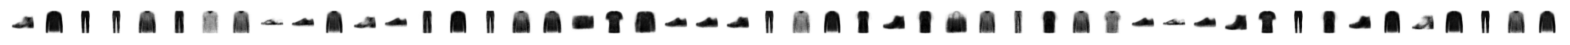

In [5]:
## Reconstructing content from the embeddings
n_to_predict = 50
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]
predictions = autoencoder.predict(example_images)

# Borrowed from https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/utils.py
import matplotlib.pyplot as plt
def display(
    images, n=n_to_predict, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")
    plt.show()
    
display(predictions)
